Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

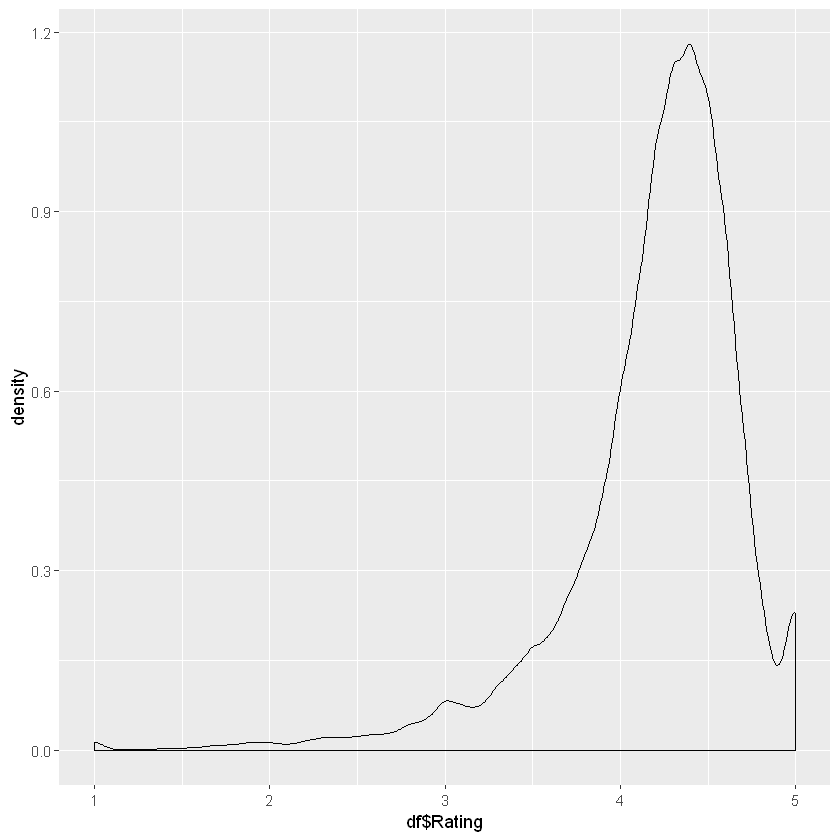

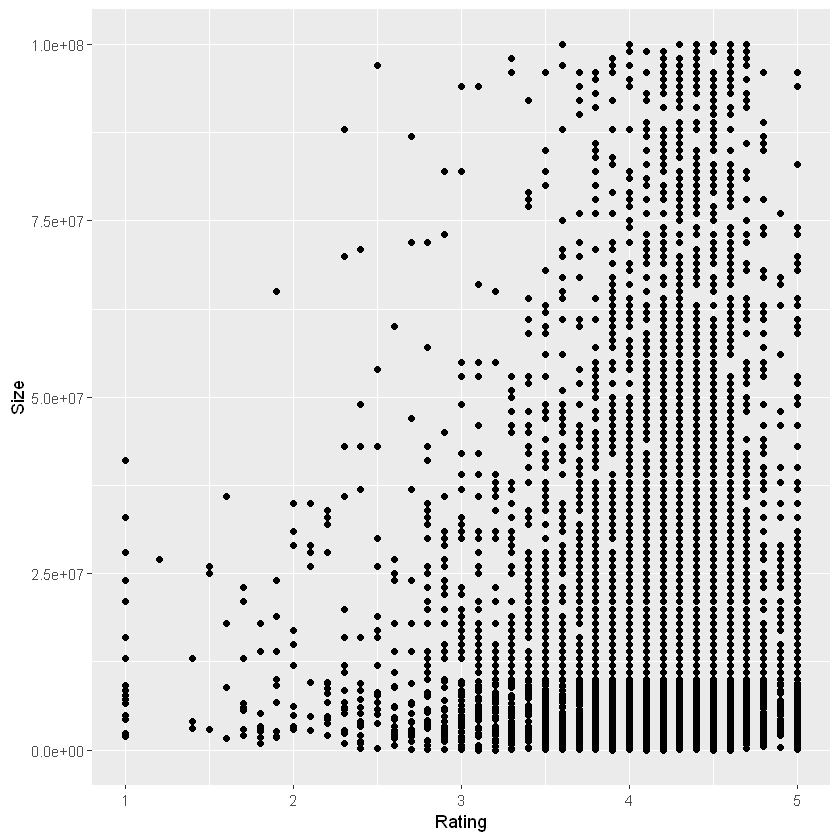

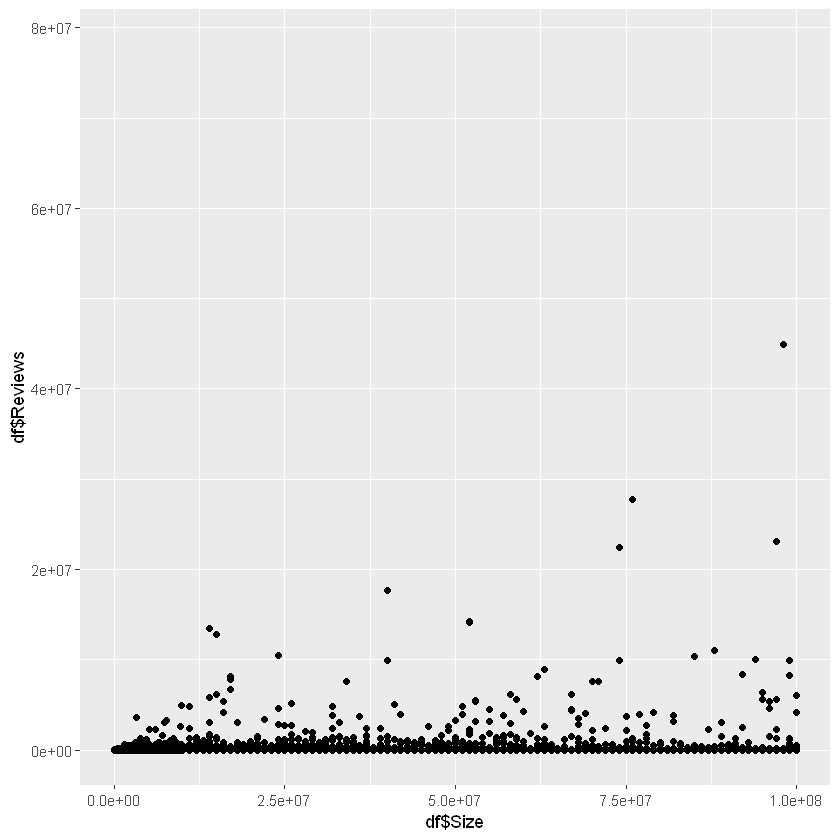

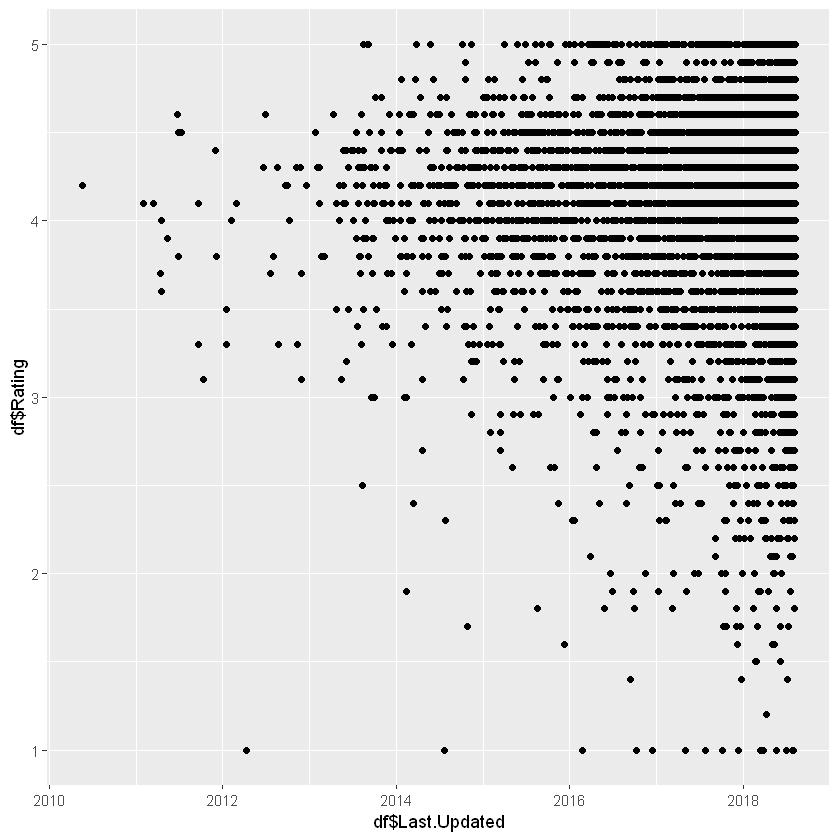

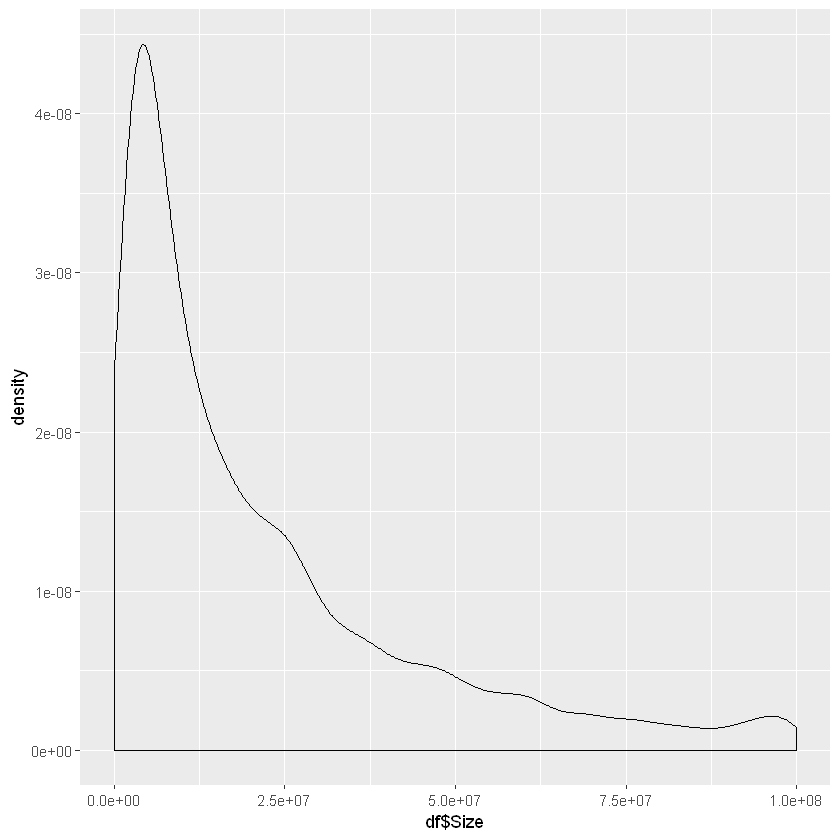

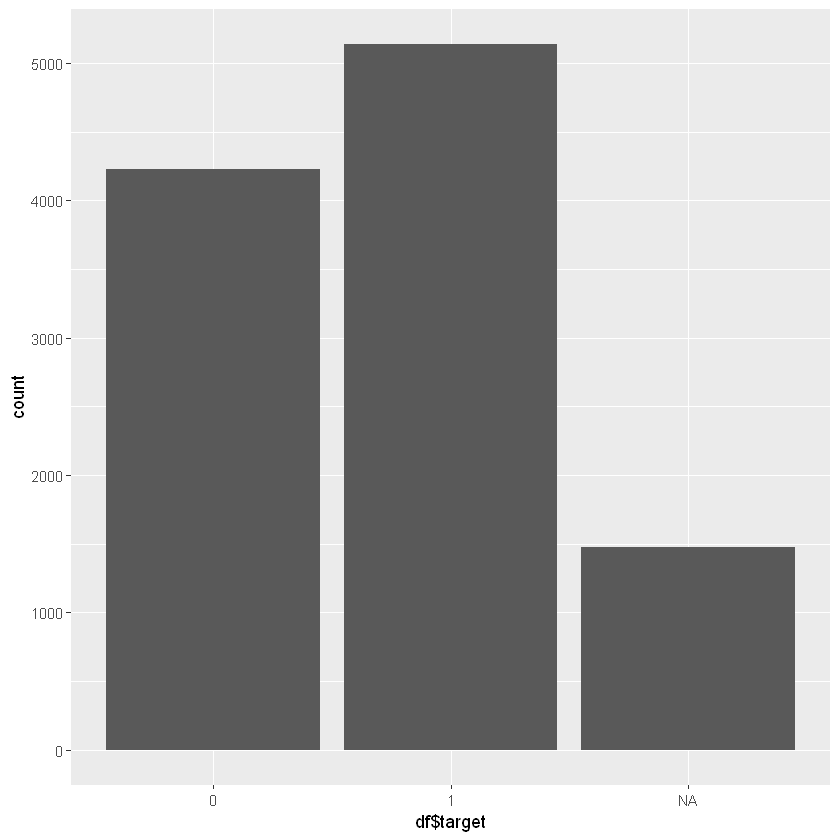

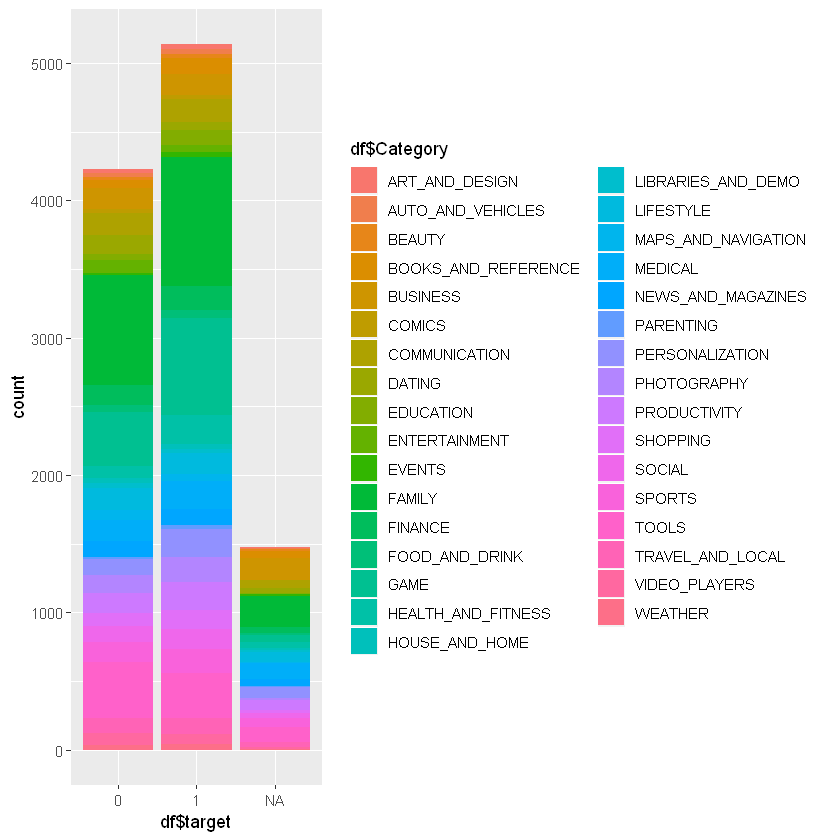

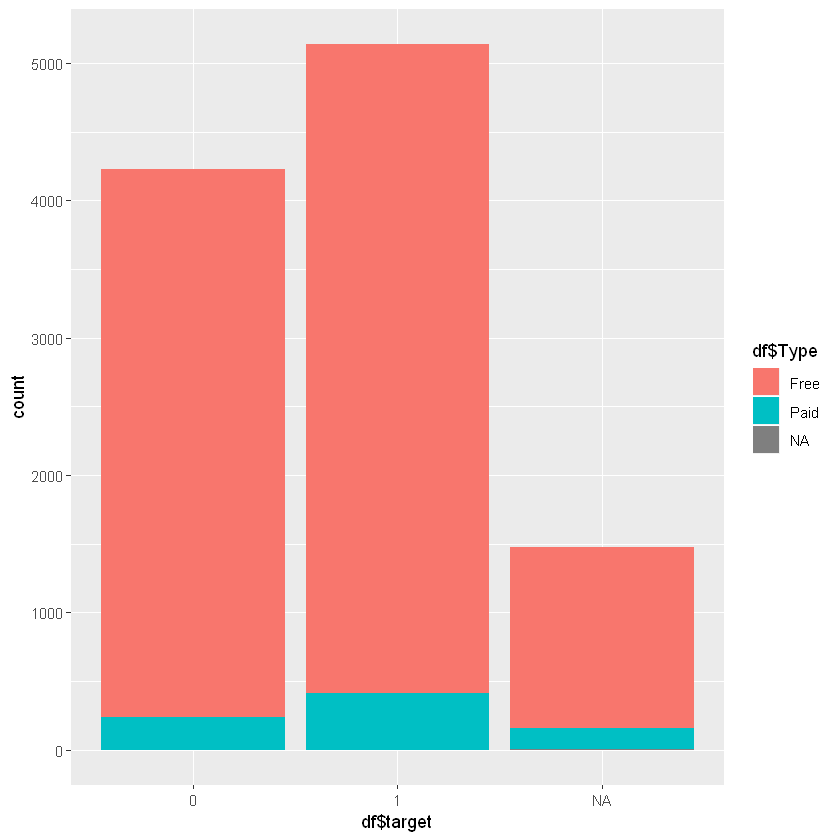

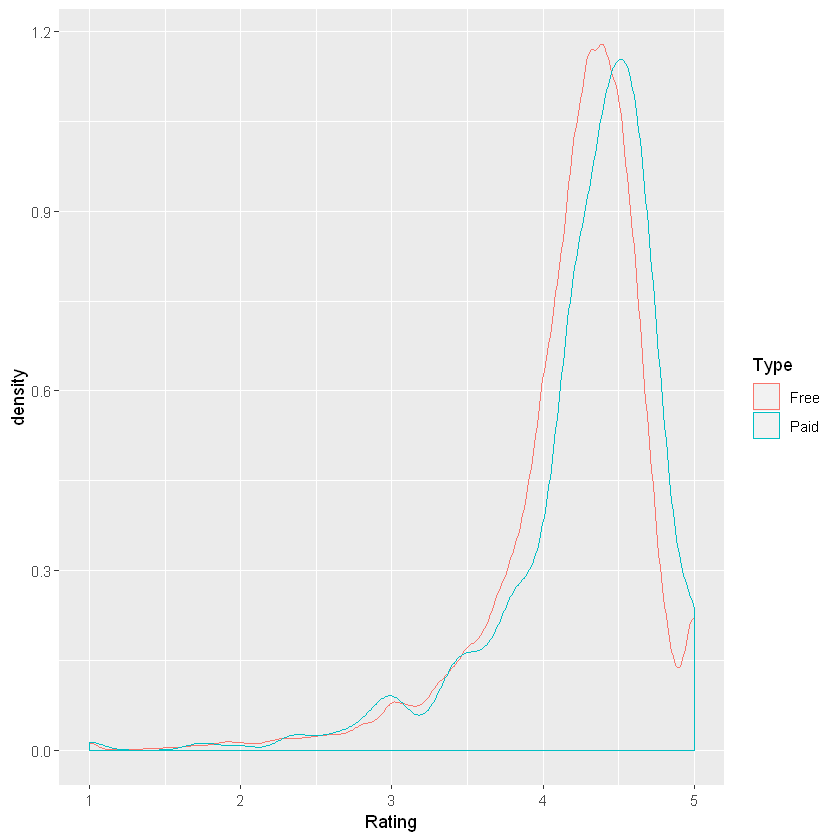

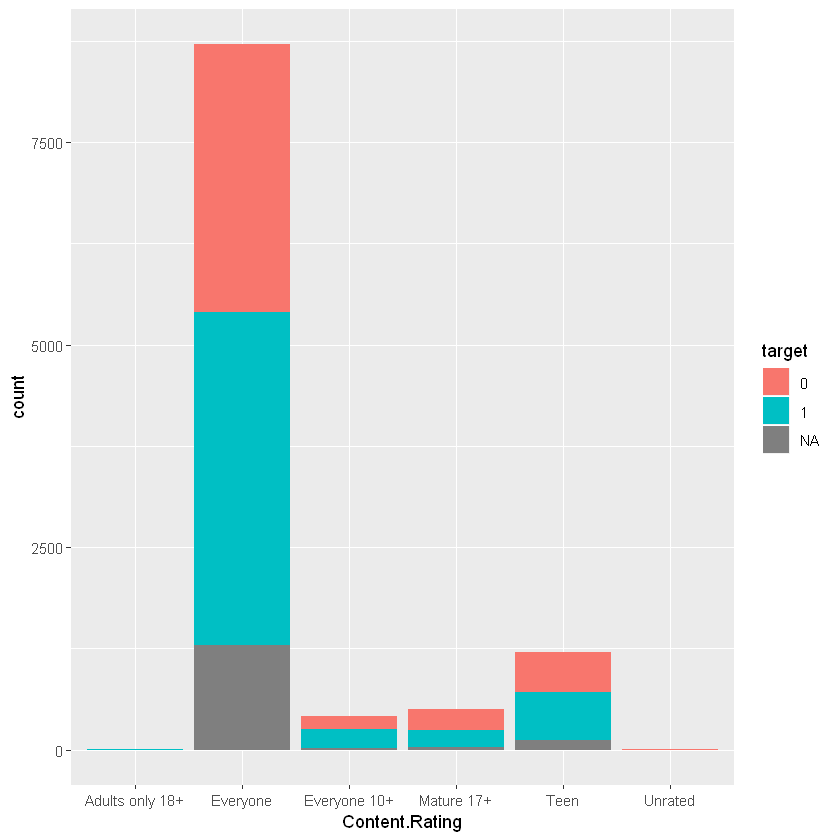

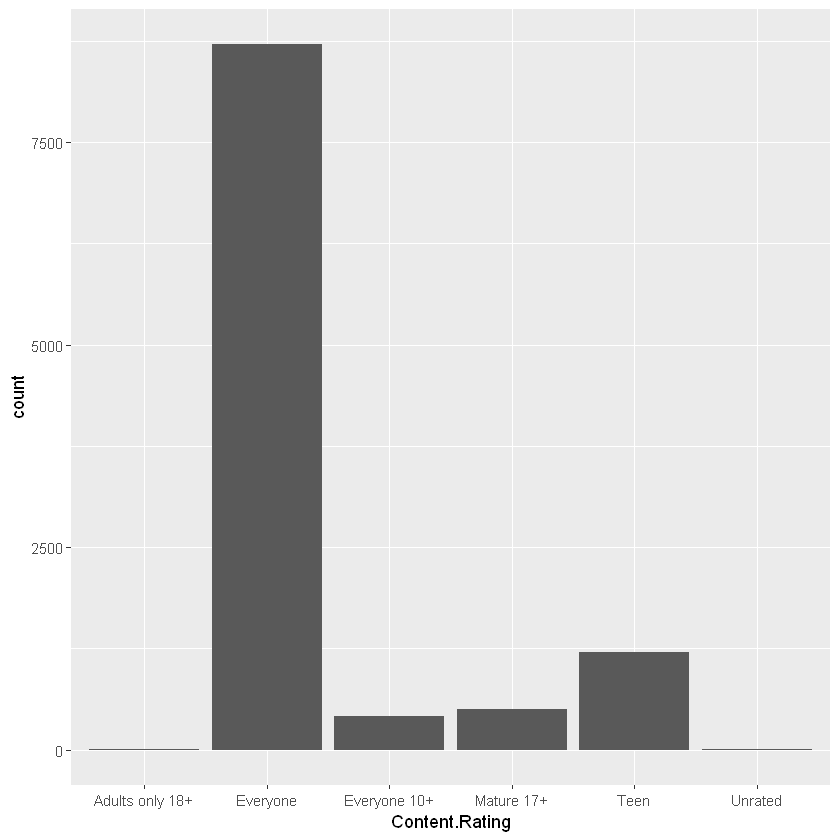

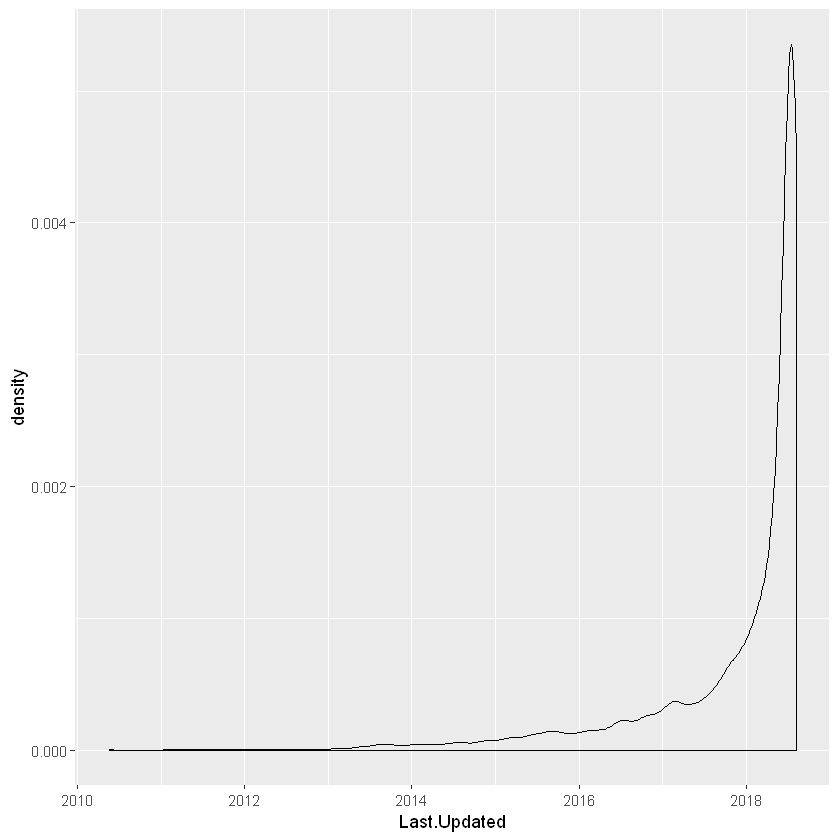

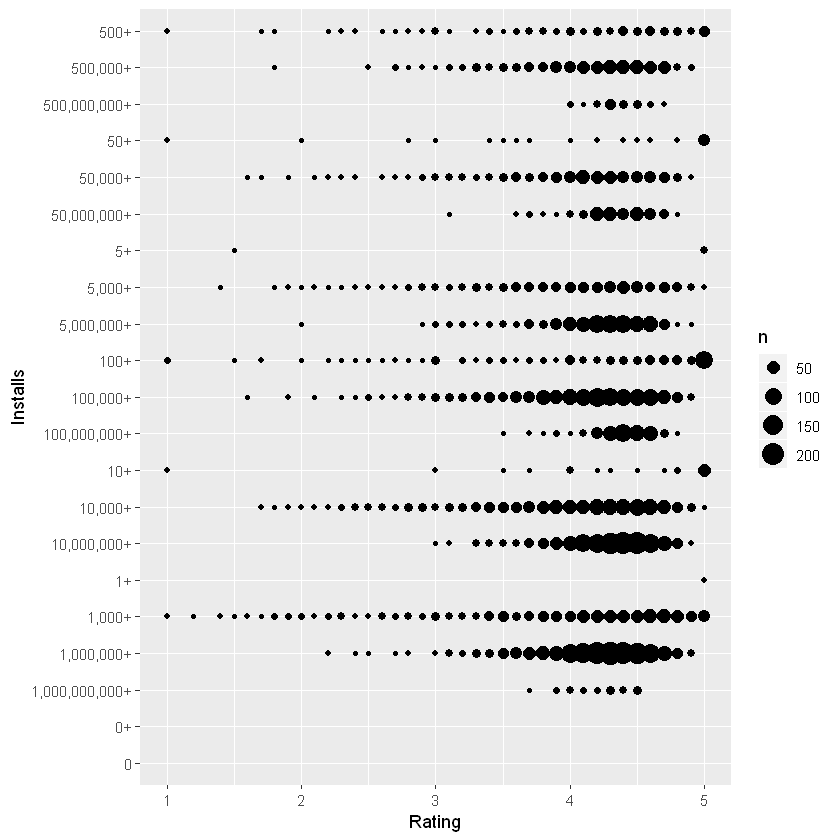

In [4]:
#Goal is to correctly predict ratings when looking at ratings as > 4 stars and <= 4 stars
#As such, ratings will need to be transformed into a dummy variable instead of numeric
#Data was pulled from Kaggle and was called Google Play Store Apps
#Was scraped directly from the google play store
#Number of apps = 10841
#Dependant Var = Rating
#Numerical variables: Reviews, Price, and Last Updated
#Categorical variables: Category, Type, Content Rating, and Genre.
#Discarded variable: Current Version, Andriod Version, and App (name)


library(caret)
library(glmnet)
library(plyr)
df = read.csv(file = "C:\\Users\\student\\Documents\\College\\18-19\\MATH 421\\Final\\googleplaystore.csv")
#Removing Invalid Rows
df$App = NULL
df$Current.Ver = NULL
df$Android.Ver = NULL
#Converting factors to numeric
df$Rating = ifelse(df$Rating>5, NA, df$Rating)
df$Price = as.numeric(as.character(df$Price))
df$Reviews = as.integer(as.character(df$Reviews))
df$Last.Updated = as.character(df$Last.Updated)
df$Last.Updated = as.Date(df$Last.Updated, format = "%d-%b-%y")
#Extra work for this one
df$Size = as.character(df$Size)
df$Size = gsub("k", "000", df$Size)
df$Size = gsub("M", "", df$Size)
df$Size = as.numeric(df$Size)
df$Size = ifelse(df$Size < 1000, df$Size*1000000,df$Size)
df$target = ifelse(df$Rating > 4.2, 1, 0)
df$target = as.factor(df$target)
levels(df$Type) = c("Free", "Free", NA, "Paid")

#Taking care of the bad data
df$Category = revalue(df$Category, c('1.9' = NA))
df$Installs = revalue(df$Installs, c('Free' = NA))

df = df[!is.na(df$Installs),]


#Graphs
library(ggplot2)

# Graph of the overall distribution of ratings, shows just how high the average app is rated
ggplot() + geom_density(df, mapping = aes(x = df$Rating), na.rm = TRUE)
# Graph of size to rating, shows how larger apps are always higher rated
ggplot() + geom_point(df, mapping = aes(x = df$Rating, y = df$Size), na.rm = TRUE) +
        labs(x = names(df)[2], y = names(df)[4])
# Graph of size to reviews, very slight upward trend shown, but not significant
ggplot() + geom_point(df, mapping = aes(x = df$Size, y = df$Reviews), na.rm = TRUE)
# Graph of date updated to rating, shows how almost every app that is very old but not removed is highly rated
ggplot() + geom_point(df, mapping = aes(y = df$Rating, x = df$Last.Updated), na.rm = TRUE)
# Graph of Size, the vast majority of apps are less than 10M
ggplot() + geom_density(df, mapping = aes(x = df$Size), na.rm = TRUE)
# Graph of target, slightly weighted > 4.2 stars
ggplot() + geom_bar(df, mapping = aes(x = df$target), na.rm = TRUE)
# Graph of target and category, I know this one isn't useful, but it is really pretty
ggplot() + geom_bar(df, mapping = aes(x = df$target, fill = df$Category), na.rm = TRUE)
# Graph of target and Type, a larger proportion of paid apps are > 4 stars
ggplot() + geom_bar(df, mapping = aes(x = df$target, fill = df$Type), na.rm = TRUE)
# Graph of rating split by type, shows how paid apps are higher rated
ggplot() + geom_density(df, mapping = aes(x = Rating, color = Type), na.rm = TRUE)
# Graph of target and content rating, shows that mature is slightly lower rated
ggplot() + geom_bar(df, mapping = aes(fill = target, x = Content.Rating), na.rm = TRUE)
# Graph of Content Rating, shows how 10+ is a strangely small category
ggplot() + geom_bar(df, mapping = aes(x = Content.Rating), na.rm = TRUE)
# Graph of date updated, shows a near exponential curve, showing how most app are updating constantly
ggplot() + geom_density(df, mapping = aes(x = Last.Updated), na.rm = TRUE)
# Graph of rating and number of installs, shows how higher installs generally correlate with higher ratings
ggplot() + geom_count(df, mapping = aes(x = Rating, y = Installs), na.rm = TRUE)

In [5]:
#Handling missing data
#first off, delete Rating column, should have not been here, but was good for graphs
df$Rating = NULL

#method one: nuke
df1 = df[complete.cases(df),]

#method two: impute the mean and use mode for categorical. Simply replaces NA's with the
CorrectNA = function(x){
  
  for(i in 1:ncol(x)){
    
    if(is.numeric(x[,i])){
      x[,i][is.na(x[,i])] = mean(x[,i], na.rm=TRUE)
      
    }else if(is.factor(x[,i])){
      uniqx = unique(x[,i])
      x[,i][is.na(x[,i])] = uniqx[which.max(tabulate(match(x[,i], uniqx)))]
    }
    
  }
  return(x)
}


df2 = CorrectNA(df)
#method three: impute using knn method for numerics. KNN attempts to use the data to determine 
#the proper value to replace with, it is a "smart" replacement. It also standardizes the data
fixing = preProcess(df, method='knnImpute')
df3 = predict(fixing, newdata = df)
df3 = CorrectNA(df3)


#recoding/encoding categoricals
df4 = df1
df5 = df2
df6 = df3

levels(df4$Category) = c("Fun", "Convenience", "Fun", "Convenience", "Business", "Fun", 
                         "Convenience","Fun", "Convenience", "Fun", "Fun", "Family", 
                         "Business", "Fun", "Fun", "Needs", "Convenience", "Convenience",
                         "Convenience", "Needs", "Needs", "Convenience", "Convenience", "Fun",
                         "Fun", "Business", "Convenience", "Fun", "Fun", "Needs", "Convenience",
                         "Fun", "Convenience")
levels(df4$Installs) = c(0,0,1000000000,1000000,1000,0,10000000,10000,0,100000000,100000,0,
                         1000000,1000,0,10000000,10000,0,100000000,100000,0)

levels(df5$Category) = c("Fun", "Convenience", "Fun", "Convenience", "Business", "Fun", 
                         "Convenience","Fun", "Convenience", "Fun", "Fun", "Family", 
                         "Business", "Fun", "Fun", "Needs", "Convenience", "Convenience",
                         "Convenience", "Needs", "Needs", "Convenience", "Convenience", "Fun",
                         "Fun", "Business", "Convenience", "Fun", "Fun", "Needs", "Convenience",
                         "Fun", "Convenience")
levels(df5$Installs) = c(0,0,1000000000,1000000,1000,0,10000000,10000,0,100000000,100000,0,
                         1000000,1000,0,10000000,10000,0,100000000,100000,0)

levels(df6$Category) = c("Fun", "Convenience", "Fun", "Convenience", "Business", "Fun", 
                         "Convenience","Fun", "Convenience", "Fun", "Fun", "Family", 
                         "Business", "Fun", "Fun", "Needs", "Convenience", "Convenience",
                         "Convenience", "Needs", "Needs", "Convenience", "Convenience", "Fun",
                         "Fun", "Business", "Convenience", "Fun", "Fun", "Needs", "Convenience",
                         "Fun", "Convenience")
levels(df6$Installs) = c(0,0,1000000000,1000000,1000,0,10000000,10000,0,100000000,100000,0,
                         1000000,1000,0,10000000,10000,0,100000000,100000,0)


#too many to bother with "genres"
df4$Genres = NULL
df5$Genres = NULL
df6$Genres = NULL
#encoding
#Dummy encoding
dummy1 <- dummyVars(target ~ ., data=df4)
dummy2 <- predict(dummy1, newdata = df4)
df7 <- data.frame(dummy2)
df7$target <- df4$target

dummy1 <- dummyVars(target ~ ., data=df5)
dummy2 <- predict(dummy1, newdata = df5)
df8 <- data.frame(dummy2)
df8$target <- df5$target

dummy1 <- dummyVars(target ~ ., data=df6)
dummy2 <- predict(dummy1, newdata = df6)
df9 <- data.frame(dummy2)
df9$target <- df6$target


#Convert to as numeric
df10 = df4
df10$Category = as.numeric(df10$Category)
df10$Installs = as.numeric(df10$Installs)
df10$Type = as.numeric(df10$Type)
df10$Content.Rating = as.numeric(df10$Content.Rating)

df11 = df5
df11$Category = as.numeric(df11$Category)
df11$Installs = as.numeric(df11$Installs)
df11$Type = as.numeric(df11$Type)
df11$Content.Rating = as.numeric(df11$Content.Rating)

df12 = df6
df12$Category = as.numeric(df12$Category)
df12$Installs = as.numeric(df12$Installs)
df12$Type = as.numeric(df12$Type)
df12$Content.Rating = as.numeric(df12$Content.Rating)

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'target' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'target' is not a factor"Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'target' is not a factor"

In [6]:
# Models
library(caret)
library(ranger)
print("this is working")
#after one runthrough,extratrees is always smaller, so eliminated
myGrid = expand.grid(mtry = c(1:8), splitrule = c("gini"),
                     min.node.size = c(1:10))

mranger <- train(target~.,data = df1, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger$results$Accuracy)

#Ran on one dataset to get ideal parameters, now running on all datasets.
#mtry = 8, splitrule = gini, min.node.size = 2
myGrid = expand.grid(mtry = 8, splitrule = c("gini"),
                     min.node.size = 2)

mranger1 <- train(target~.,data = df1, method = "ranger", 
                trControl = trainControl(method ="cv", number = 7),
                tuneGrid = myGrid)
max(mranger1$results$Accuracy)

mranger2 <- train(target~.,data = df2, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger2$results$Accuracy)

mranger3 <- train(target~.,data = df3, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger3$results$Accuracy)

mranger4 <- train(target~.,data = df4, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger4$results$Accuracy)

mranger5 <- train(target~.,data = df5, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger5$results$Accuracy)

mranger6 <- train(target~.,data = df6, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger6$results$Accuracy)

mranger7 <- train(target~.,data = df7, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger7$results$Accuracy)

mranger8 <- train(target~.,data = df8, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger8$results$Accuracy)

mranger9 <- train(target~.,data = df9, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger9$results$Accuracy)

mranger10 <- train(target~.,data = df10, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger10$results$Accuracy)

mranger11 <- train(target~.,data = df11, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger11$results$Accuracy)

mranger12 <- train(target~.,data = df12, method = "ranger", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid)
max(mranger12$results$Accuracy)

#Highest Accuracy model used df9 which was knn imputed, recoded and dummy variable encoded.
#Accuraccy = .727399

myGrid2 = expand.grid(alpha = 0:1, lambda = seq(.000001, 1, .2))

mglmnet <- train(target~.,data = df1, method = "glmnet", 
                trControl = trainControl(method ="cv", number = 7),
                                tuneGrid = myGrid2)
#Ran on one dataset to get ideal parameters, now running on all datasets.
#alpha = 1, lambda = .000001

myGrid2 = expand.grid(alpha = 1, lambda = .000001)

mglmnet1 <- train(target~.,data = df1, method = "glmnet", 
                 trControl = trainControl(method ="cv", number = 7),
                 tuneGrid = myGrid2)
max(mglmnet1$results$Accuracy)

mglmnet2 <- train(target~.,data = df2, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet2$results$Accuracy)

mglmnet3 <- train(target~.,data = df3, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet3$results$Accuracy)

mglmnet4 <- train(target~.,data = df4, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet4$results$Accuracy)

mglmnet5 <- train(target~.,data = df5, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet5$results$Accuracy)

mglmnet6 <- train(target~.,data = df6, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet6$results$Accuracy)

mglmnet7 <- train(target~.,data = df7, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet7$results$Accuracy)

mglmnet8 <- train(target~.,data = df8, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet8$results$Accuracy)

mglmnet9 <- train(target~.,data = df9, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet9$results$Accuracy)

mglmnet10 <- train(target~.,data = df10, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet10$results$Accuracy)

mglmnet11 <- train(target~.,data = df11, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet11$results$Accuracy)

mglmnet12 <- train(target~.,data = df12, method = "glmnet", 
                  trControl = trainControl(method ="cv", number = 7),
                  tuneGrid = myGrid2)
max(mglmnet12$results$Accuracy)

#Best model used df2 which is mean imputed for missing numerical values, categorically
#imptuted for categorical, and no other adjustments .6699248

library(arm)
#Bayesian Generalized Linear model bayesglm
mbayes1 <- train(target~.,data = df1, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes1$results$Accuracy

mbayes2 <- train(target~.,data = df2, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes2$results$Accuracy

mbayes3 <- train(target~.,data = df3, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes3$results$Accuracy

mbayes4 <- train(target~.,data = df4, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes4$results$Accuracy

mbayes5 <- train(target~.,data = df5, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes5$results$Accuracy

mbayes6 <- train(target~.,data = df6, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes6$results$Accuracy

mbayes7 <- train(target~.,data = df7, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes7$results$Accuracy

mbayes8 <- train(target~.,data = df8, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes8$results$Accuracy

mbayes9 <- train(target~.,data = df9, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes9$results$Accuracy

mbayes10 <- train(target~.,data = df10, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes10$results$Accuracy

mbayes11 <- train(target~.,data = df11, method = "bayesglm", 
                 trControl = trainControl(method ="cv", number = 7))
mbayes11$results$Accuracy

mbayes12 <- train(target~.,data = df12, method = "bayesglm", 
                  trControl = trainControl(method ="cv", number = 7))
mbayes12$results$Accuracy
#Best model used df2 with accuracy = .6714947


mrpart1 <- train(target~.,data = df1, method = "rpart", 
                trControl = trainControl(method ="cv", number = 7))
mrpart1$results$Accuracy
mrpart2 <- train(target~.,data = df2, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart2$results$Accuracy
mrpart3 <- train(target~.,data = df3, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart3$results$Accuracy
mrpart4 <- train(target~.,data = df4, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart4$results$Accuracy
mrpart5 <- train(target~.,data = df5, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart5$results$Accuracy
mrpart6 <- train(target~.,data = df6, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart6$results$Accuracy
mrpart7 <- train(target~.,data = df7, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart7$results$Accuracy
mrpart8 <- train(target~.,data = df8, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart8$results$Accuracy
mrpart9 <- train(target~.,data = df9, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart9$results$Accuracy
mrpart10 <- train(target~.,data = df10, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart10$results$Accuracy
mrpart11 <- train(target~.,data = df11, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart11$results$Accuracy
mrpart12 <- train(target~.,data = df12, method = "rpart", 
                 trControl = trainControl(method ="cv", number = 7))
mrpart12$results$Accuracy
#Best model used df2 with accuracy = .6700142, parameter cp = .003845244



#Overall best model was df9 with ranger model using parameters 
#mtry = 8, splitrule = gini, min.node.size = 2
#Dummy encoding, categorical recoding, and knn imputing were all used to get this value.

[1] "this is working"


[1] 0.6620578

[1] 0.6601126

[1] 0.7072884

[1] 0.7042428

[1] 0.6777061

[1] 0.7270291

[1] 0.7250002

[1] 0.6771921

[1] 0.7271239

[1] 0.7232469

[1] 0.6740873

[1] 0.716973

[1] 0.72288

[1] 0.6320305

[1] 0.6703882

[1] 0.6672492

[1] 0.6087431

[1] 0.6535062

[1] 0.6524874

[1] 0.6104281

[1] 0.6536876

[1] 0.6522156

[1] 0.5965884

[1] 0.6390228

[1] 0.6389306

Loading required package: MASS
Loading required package: lme4

arm (Version 1.10-1, built: 2018-4-12)

Working directory is C:/Users/student

Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"

[1] 0.6343611

[1] 0.6690041

[1] 0.6698325

Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"

[1] 0.6078427

[1] 0.6529501

[1] 0.6539672

Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"

[1] 0.6065496

[1] 0.6547971

[1] 0.6515702

Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"Warning message:
"fitted probabilities numerically 0 or 1 occurred"

[1] 0.5963266

[1] 0.6382847

[1] 0.6392077

[1] 0.5946472 0.5929650 0.5770393

[1] 0.6685432 0.6612549 0.6307268

[1] 0.6728814 0.6581193 0.6350547

[1] 0.5943870 0.5936114 0.5686287

[1] 0.6631000 0.6619928 0.6357927

[1] 0.6639289 0.6632834 0.6286026

[1] 0.5990426 0.5950312 0.5606195

[1] 0.6533177 0.6455685 0.6403117

[1] 0.6522116 0.6471382 0.6324695

[1] 0.6026684 0.5959424 0.5547828

[1] 0.6484304 0.6421583 0.6355180

[1] 0.6521219 0.6414223 0.6167890